# SCM demo

[参考](https://zenn.dev/falconnnmmm/articles/ecf333ba18b2f7)

In [16]:
# 必要なライブラリ
import pandas as pd
import polars as pl
from scipy.optimize import minimize
import plotly.graph_objects as go # 可視化
from numpy.linalg import lstsq
import cvxpy as cp
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## データ読み込み

In [18]:
# データの読み込み
df = pd.read_stata('smoking.dta')
df = df[['state', 'year', 'cigsale', 'retprice']]
df.head()

,state,year,cigsale,retprice
0,Alabama,1970.0,89.800003,39.599998
1,Alabama,1971.0,95.400002,42.700001
2,Alabama,1972.0,101.099998,42.299999
3,Alabama,1973.0,102.900002,42.099998
4,Alabama,1974.0,108.199997,43.099998


In [19]:
# 年で行・州で列に並べ替え（panel → wide）
wide = df.pivot(index="year", columns="state", values="cigsale").sort_index()

treated = "California"
donors   = [s for s in wide.columns if s != treated]

# pre_years  = list(range(1970, 1989))   # 1970–88
# post_years = list(range(1989, 2001))   # 1989–2000
pre_years  = list(range(1970, 1981))
post_years = list(range(1982, 1988))

## OLS

In [20]:
X_pre = wide.loc[pre_years, donors].values      # (T_pre × J)
y_pre = wide.loc[pre_years, treated].values     # (T_pre,)

beta_ols, *_ = lstsq(X_pre, y_pre, rcond=None)  # J × 1

# 係数と予測値
ols_weights = pd.Series(beta_ols, index=donors, name="OLS β")
y_hat_ols   = wide[donors] @ beta_ols           # 全期間の合成系列


## SCM

In [21]:
W = cp.Variable(len(donors))                # J × 1
objective   = cp.Minimize(cp.sum_squares(y_pre - X_pre @ W))
constraints = [W >= 0, cp.sum(W) == 1]
prob = cp.Problem(objective, constraints)
prob.solve()

sc_weights  = pd.Series(W.value, index=donors, name="SC weight")
y_hat_sc    = wide[donors] @ sc_weights


In [22]:
# 重み確認
weights = pd.concat([ols_weights, sc_weights], axis=1).fillna(0)
print(weights.sort_values("SC weight", ascending=False).head(10))

                  OLS β     SC weight
Utah           0.052554  3.382438e-01
Connecticut    0.101516  3.179692e-01
Nevada         0.173134  2.901517e-01
West Virginia  0.129441  5.363527e-02
New Hampshire  0.010620  1.919597e-17
Delaware       0.107240 -9.485114e-18
Idaho          0.013730 -5.011072e-17
Indiana       -0.056673 -5.017672e-17
Montana        0.053187 -5.330319e-17
Colorado       0.029031 -6.640264e-17


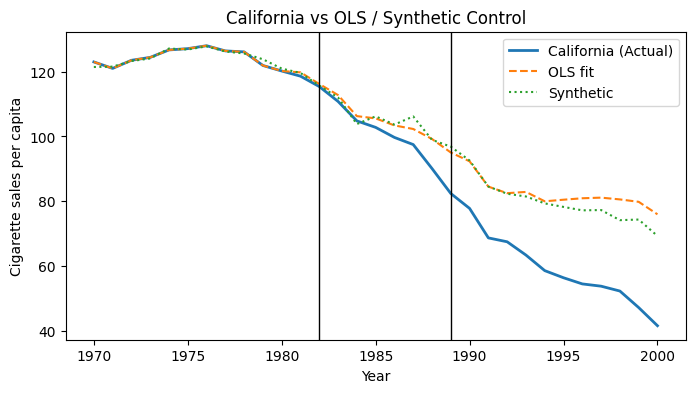

In [25]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(wide.index, wide[treated],   label="California (Actual)", lw=2)
ax.plot(wide.index, y_hat_ols,       label="OLS fit",   ls="--")
ax.plot(wide.index, y_hat_sc,        label="Synthetic", ls=":")
ax.axvline(1982, color="k", lw=1)
ax.axvline(1989, color="k", lw=1)
ax.set_xlabel("Year"); ax.set_ylabel("Cigarette sales per capita")
ax.legend(); ax.set_title("California vs OLS / Synthetic Control")
plt.show()
